In [1]:
import torch
import json
import numpy as np
import pickle
from tqdm import tqdm
from pathlib import Path

import matplotlib.pyplot as plt

from s4hci.utils.data_handling import load_adi_data
from s4hci.models.noise import S4Ridge

import torch.nn.functional as F
import torch.multiprocessing as mp

from s4hci.utils.masks import construct_round_rfrr_template, construct_rfrr_mask

## Load the data

In [2]:
dataset_config_file = "../../../../70_results/x1_s4_cross_validation/0100_C-0656-A/dataset.json"

with open(dataset_config_file) as json_file:
    dataset_config = json.load(json_file)

print("Loading data ... ", end='')
science_data, raw_angles, raw_psf_template_data = \
    load_adi_data(dataset_config["file_path"],
                  data_tag=dataset_config["stack_key"],
                  psf_template_tag=dataset_config["psf_template_key"],
                  para_tag=dataset_config["parang_key"])

psf_template_data = np.mean(raw_psf_template_data, axis=0)

X_train = science_data[0::5]
X_test = science_data[1::2]
print("[DONE]")

Loading data ... [DONE]


## Data preparation

In [3]:
image_size = X_train.shape[1]

template_cut, _ = construct_round_rfrr_template(
    radius=4,
    psf_template_in=psf_template_data)

right_reason_mask = construct_rfrr_mask(
    template_setup=("radius", 8),
    psf_template_in=template_cut,
    mask_size_in=image_size)

In [4]:
print("Normalizing data ... ", end='')
mean_frame = np.mean(X_train, axis=0)
science_data = X_train - mean_frame

std_frame = np.std(science_data, axis=0)
science_data_norm = science_data / std_frame

template_norm = template_cut / np.max(np.abs(template_cut))

print("[DONE]")

Normalizing data ... [DONE]


## Implement the current math for a single position

In [5]:
half_precision = False
rank = 0
positions = [(20, 20), (40, 60), (30, 30), (60, 60)]
alpha = 10

In [6]:
# get all the data we need as pytroch tensors
X_torch = torch.from_numpy(science_data_norm).unsqueeze(1)
p_torch = torch.from_numpy(template_norm).unsqueeze(0).unsqueeze(0)
M_torch = torch.from_numpy(right_reason_mask)
eye = torch.eye(image_size**2, image_size**2) * alpha

if half_precision:
    X_torch = X_torch.float()
    p_torch = p_torch.float()
    M_torch = M_torch.float()

# send everything to the current GPU / device
X_torch = X_torch.to(rank)
p_torch = p_torch.to(rank)
M_torch = M_torch.to(rank)
eye = eye.to(rank)

# convolve the data
X_conv = F.conv2d(X_torch, p_torch, padding="same").view(X_torch.shape[0], -1)
X_conv_square = X_conv.T @ X_conv

# Compute all betas in a loop over all positions
betas = []

for x, y in tqdm(positions):
    tmp_idx = x * image_size + y

    # get the current mask
    m_torch = M_torch[tmp_idx].flatten()
    Y_torch = X_torch.view(X_torch.shape[0], -1)[:, tmp_idx]

    # compute MPX^TXPM + lambda * eye
    matrix_within = ((X_conv_square * m_torch).T * m_torch).T + eye

    # compute beta
    beta = torch.linalg.inv(matrix_within) @ (
                X_conv * m_torch).T @ Y_torch
    beta_cut = (beta * m_torch).cpu()

    betas.append(beta_cut.cpu())

# Convolve the results
betas_conv = torch.stack(betas).reshape(
    len(betas), 1, image_size, image_size).to(rank)

beta_conv = F.conv2d(
    betas_conv, p_torch, padding="same")

beta_conv = beta_conv.squeeze().cpu()

100%|██████████| 4/4 [00:10<00:00,  2.69s/it]


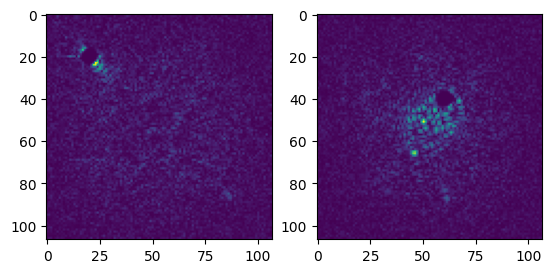

In [7]:
ax1 = plt.subplot(1, 2, 1)
ax1.imshow(torch.abs(beta_conv)[0])

ax2 = plt.subplot(1, 2, 2)
ax2.imshow(torch.abs(beta_conv)[1])

## Same implementation but with lsqr

In [31]:
half_precision = False

In [32]:
alpha=100

In [32]:
# get all the data we need as pytroch tensors
X_torch = torch.from_numpy(science_data_norm).unsqueeze(1)
p_torch = torch.from_numpy(template_norm).unsqueeze(0).unsqueeze(0)
M_torch = torch.from_numpy(right_reason_mask)
eye = torch.eye(image_size**2, image_size**2) * 10

if half_precision:
    X_torch = X_torch.float()
    p_torch = p_torch.float()
    M_torch = M_torch.float()

# send everything to the current GPU / device
X_torch = X_torch.to(rank)
p_torch = p_torch.to(rank)
M_torch = M_torch.to(rank)
eye = eye.to(rank)

# convolve the data
X_conv = F.conv2d(X_torch, p_torch, padding="same").view(X_torch.shape[0], -1)
#X_conv = X_torch.view(X_torch.shape[0], -1)
X_conv_square = X_conv.T @ X_conv

# Compute all betas in a loop over all positions
betas = []

for x, y in tqdm(positions):
    tmp_idx = x * image_size + y

    # get the current mask
    m_torch = M_torch[tmp_idx].flatten()
    Y_torch = X_torch.view(X_torch.shape[0], -1)[:, tmp_idx]

    # compute MPX^TXPM + lambda * eye
    lhs = ((X_conv_square * m_torch).T * m_torch).T + eye
    rhs = (X_conv * m_torch).T @ Y_torch

    # compute beta
    beta = torch.linalg.lstsq(lhs, rhs.view(-1,1))
    
    beta_cut = (beta.solution.squeeze() * m_torch)

    betas.append(beta_cut)

# Convolve the results
betas_conv = torch.stack(betas).cpu().reshape(
    len(betas), 1, image_size, image_size).to(rank)

beta_conv = F.conv2d(
    betas_conv, p_torch, padding="same")

#beta_conv = betas_conv

beta_conv = beta_conv.squeeze().cpu()

100%|██████████| 4/4 [00:03<00:00,  1.21it/s]


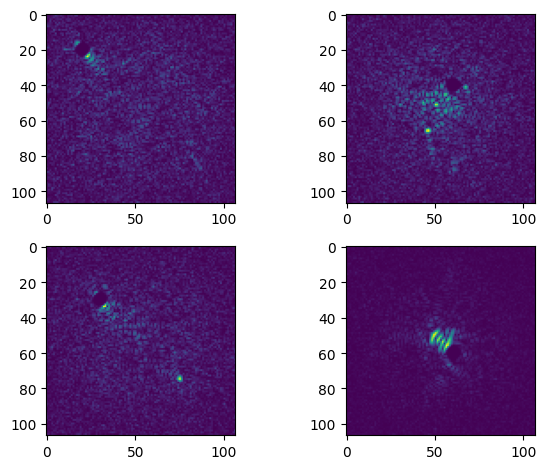

In [33]:
ax1 = plt.subplot(2, 2, 1)
ax1.imshow(torch.abs(beta_conv)[0])

ax2 = plt.subplot(2, 2, 2)
ax2.imshow(torch.abs(beta_conv[1]))

ax2 = plt.subplot(2, 2, 3)
ax2.imshow(torch.abs(beta_conv[2]))

ax2 = plt.subplot(2, 2, 4)
ax2.imshow(torch.abs(beta_conv[3]))

plt.tight_layout()

batch of lstqr

In [6]:
# get all the data we need as pytroch tensors
X_torch = torch.from_numpy(science_data_norm).unsqueeze(1)
p_torch = torch.from_numpy(template_norm).unsqueeze(0).unsqueeze(0)
M_torch = torch.from_numpy(right_reason_mask)
eye = torch.eye(image_size**2, image_size**2) * alpha

if half_precision:
    X_torch = X_torch.float()
    p_torch = p_torch.float()
    M_torch = M_torch.float()

# send everything to the current GPU / device
X_torch = X_torch.to(rank)
p_torch = p_torch.to(rank)
M_torch = M_torch.to(rank)
eye = eye.to(rank)

# convolve the data
X_conv = F.conv2d(X_torch, p_torch, padding="same").view(X_torch.shape[0], -1)
X_conv_square = X_conv.T @ X_conv

In [7]:
x, y = positions[1]
tmp_idx = x * image_size + y

# get the current mask
m_torch = M_torch[tmp_idx].flatten()
Y_torch = X_torch.view(X_torch.shape[0], -1)[:, tmp_idx]

In [15]:
# compute MPX^TXPM + lambda * eye
lhs = ((X_conv_square * m_torch).T * m_torch).T + eye
rhs = (X_conv * m_torch).T @ Y_torch

In [9]:
rhs = torch.stack([rhs, rhs, rhs])

In [10]:
lhs = torch.stack([lhs, lhs, lhs])

In [14]:
%%time 
beta = torch.linalg.lstsq(lhs, rhs)

CPU times: user 705 ms, sys: 578 ms, total: 1.28 s
Wall time: 1.28 s


In [18]:
%%time 
beta = torch.linalg.lstsq(lhs, rhs.view(-1, 1))

CPU times: user 234 ms, sys: 155 ms, total: 388 ms
Wall time: 386 ms


## Using QR decomposition

In [216]:
# get all the data we need as pytroch tensors
X_torch = torch.from_numpy(science_data_norm).unsqueeze(1)
p_torch = torch.from_numpy(template_norm).unsqueeze(0).unsqueeze(0)
M_torch = torch.from_numpy(right_reason_mask)

if half_precision:
    X_torch = X_torch.float()
    p_torch = p_torch.float()
    M_torch = M_torch.float()

# send everything to the current GPU / device
X_torch = X_torch.to(rank)
p_torch = p_torch.to(rank)
M_torch = M_torch.to(rank)

# convolve the data
X_conv = F.conv2d(X_torch, p_torch, padding="same").view(X_torch.shape[0], -1)

In [217]:
x, y = positions[1]
tmp_idx = x * image_size + y

# get the current mask
m_torch = M_torch[tmp_idx].flatten()
Y_torch = X_torch.view(X_torch.shape[0], -1)[:, tmp_idx]

In [218]:
X_conv_cut = X_conv * m_torch

In [219]:
X_conv_cut.shape

torch.Size([13867, 11449])

In [268]:
eye = torch.eye(image_size**2, image_size**2, device=rank) * 10

In [269]:
B = torch.concat([X_conv_cut, eye])

In [270]:
Y_torch_new = torch.concat([Y_torch, torch.zeros(image_size**2, device=rank)])

In [271]:
Y_torch_new.shape

torch.Size([25316])

In [272]:
B.shape

torch.Size([25316, 11449])

In [286]:
%%time
Q, R = torch.linalg.qr(B, mode="reduced")
Q.cpu()

CPU times: user 1.4 s, sys: 1.5 s, total: 2.89 s
Wall time: 2.9 s


tensor([[-3.2143e-02, -1.9214e-02, -2.1253e-02,  ...,  3.6043e-03,
          3.8699e-03, -2.8038e-03],
        [-2.8357e-02, -1.3781e-02, -1.6316e-02,  ..., -3.9931e-03,
         -1.7299e-03, -2.7594e-04],
        [-2.1245e-02, -4.9577e-03, -5.9236e-03,  ..., -5.9621e-04,
         -7.8538e-04,  2.7767e-03],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  6.6535e-01,
         -3.8267e-01,  1.7379e-02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          6.6598e-01,  3.8320e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00, -6.4298e-01]], dtype=torch.float64)

In [274]:
R.shape

torch.Size([11449, 11449])

In [275]:
rhs = Q.T @ Y_torch_new

In [276]:
beta = torch.linalg.solve_triangular(
    R, rhs.view(-1, 1), upper=True)

In [277]:
beta_cut = (beta.squeeze() * m_torch).cpu()

In [278]:
# Convolve the results
betas_conv = torch.stack([beta_cut,]).reshape(
    1, 1, image_size, image_size).to(rank)

beta_conv = F.conv2d(
    betas_conv, p_torch, padding="same")

beta_conv = beta_conv.squeeze().cpu()

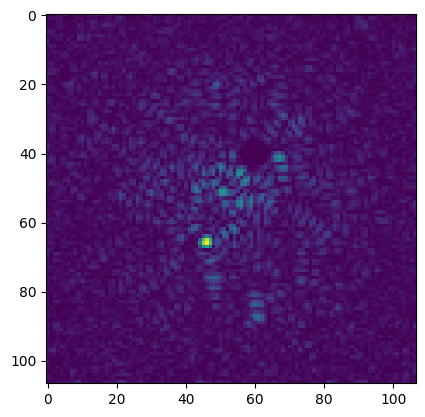

In [279]:
plt.imshow(torch.abs(beta_conv))

## QR decomposition with mask later

In [162]:
# get all the data we need as pytroch tensors
X_torch = torch.from_numpy(science_data_norm).unsqueeze(1)
p_torch = torch.from_numpy(template_norm).unsqueeze(0).unsqueeze(0)
M_torch = torch.from_numpy(right_reason_mask)

if half_precision:
    X_torch = X_torch.float()
    p_torch = p_torch.float()
    M_torch = M_torch.float()

# send everything to the current GPU / device
X_torch = X_torch.to(rank)
p_torch = p_torch.to(rank)
M_torch = M_torch.to(rank)

# convolve the data
X_conv = F.conv2d(X_torch, p_torch, padding="same").view(X_torch.shape[0], -1)

In [163]:
x, y = positions[1]
tmp_idx = x * image_size + y

# get the current mask
m_torch = M_torch[tmp_idx].flatten()
Y_torch = X_torch.view(X_torch.shape[0], -1)[:, tmp_idx]

In [164]:
eye = torch.eye(image_size**2, image_size**2, device=rank) * 10
B = torch.concat([X_conv, eye])

In [165]:
B.shape

torch.Size([25316, 11449])

In [166]:
Y_torch_new = torch.concat([Y_torch, torch.zeros(image_size**2, device=rank)])

In [167]:
Q, R = torch.linalg.qr(B)

In [ ]:
# update Q and R

In [170]:
Q_cpu = Q.cpu()
R_cpu = R.cpu()

In [ ]:
Q_new, R_new = 

In [168]:
rhs = Q.T @ Y_torch_new

In [169]:
rhs.shape

torch.Size([11449])

In [156]:
lhs = R * m_torch

In [160]:
beta = torch.linalg.solve(
    lhs, rhs.view(-1, 1))

RuntimeError: linalg.solve: A must be batches of square matrices, but they are 25316 by 11449 matrices

In [148]:
beta_cut = (beta.squeeze() * m_torch).cpu()

In [149]:
# Convolve the results
betas_conv = torch.stack([beta_cut,]).reshape(
    1, 1, image_size, image_size).to(rank)

beta_conv = F.conv2d(
    betas_conv, p_torch, padding="same")

beta_conv = beta_conv.squeeze().cpu()

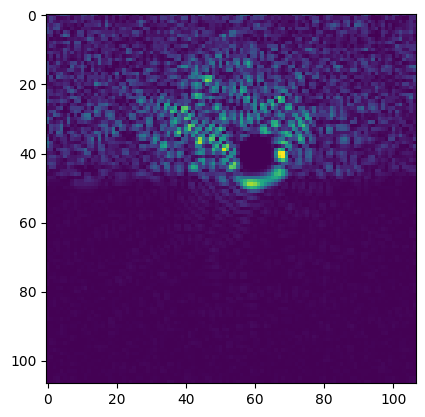

In [150]:
plt.imshow(torch.abs(beta_conv))

## Using the LU decomposition

In [6]:
alpha=100

In [67]:
# get all the data we need as pytroch tensors
X_torch = torch.from_numpy(science_data_norm).unsqueeze(1)
p_torch = torch.from_numpy(template_norm).unsqueeze(0).unsqueeze(0)
M_torch = torch.from_numpy(right_reason_mask)
eye = torch.eye(image_size**2, image_size**2) * 100

if half_precision:
    X_torch = X_torch.float()
    p_torch = p_torch.float()
    M_torch = M_torch.float()

# send everything to the current GPU / device
X_torch = X_torch.to(rank)
p_torch = p_torch.to(rank)
M_torch = M_torch.to(rank)
eye = eye.to(rank)

# convolve the data
X_conv = F.conv2d(X_torch, p_torch, padding="same").view(X_torch.shape[0], -1)
X_conv_square = X_conv.T @ X_conv

# Compute all betas in a loop over all positions
betas = []

for x, y in tqdm(positions):
    tmp_idx = x * image_size + y

    # get the current mask
    m_torch = M_torch[tmp_idx].flatten()
    Y_torch = X_torch.view(X_torch.shape[0], -1)[:, tmp_idx]
    
    # compute beta
    # compute MPX^TXPM + lambda * eye
    eye = torch.eye(image_size**2, image_size**2, device=rank) * m_torch
    lhs = ((X_conv_square * m_torch).T * m_torch).T + eye
    P, L, U = torch.linalg.lu(lhs, pivot=True)
    #rhs = P.T @ (X_conv * m_torch).T @ Y_torch
    #LU, P = torch.linalg.lu_factor(lhs) 
    rhs = P.T @(X_conv * m_torch).T @ Y_torch
    #beta = torch.lu_solve(rhs.view(-1,1), LU, P)
    
    U_tmp = U #+ torch.diag(torch.abs(m_torch -1 )).double()
    
    
    y = torch.linalg.solve_triangular(
        L, rhs.view(-1,1), upper=False)
    beta = torch.linalg.solve_triangular(
        U_tmp, y, upper=True)
    
    beta_cut = (beta.squeeze() * m_torch).cpu()

    betas.append(beta_cut.cpu())

# Convolve the results
betas_conv = torch.stack(betas).reshape(
    len(betas), 1, image_size, image_size).to(rank)

beta_conv = F.conv2d(
    betas_conv, p_torch, padding="same")

beta_conv = beta_conv.squeeze().cpu()

100%|██████████| 4/4 [00:08<00:00,  2.05s/it]


In [72]:
U

tensor([[ 1.2807e+06,  1.7774e+06,  2.1501e+06,  ...,  1.3729e+06,
          1.2023e+06,  9.1148e+05],
        [ 0.0000e+00, -8.1074e+04, -2.0013e+05,  ..., -2.0215e+05,
         -1.7615e+05, -1.3260e+05],
        [ 0.0000e+00,  0.0000e+00,  3.4383e+04,  ...,  8.1996e+04,
          6.8407e+04,  4.9541e+04],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  1.3798e+01,
          1.3048e+01,  7.4000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
         -1.8204e+01, -3.7057e+01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00, -1.4054e+01]], device='cuda:0', dtype=torch.float64)

In [80]:
M_new = torch.diag(m_torch).double()[:,m_torch==1]

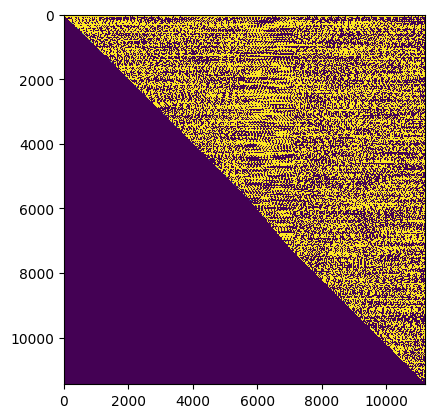

In [84]:
plt.imshow((U @ M_new).cpu(), vmin= 0, vmax=1)

In [88]:
MM = torch.triu((U @ M_new).cpu().T, diagonal=1)

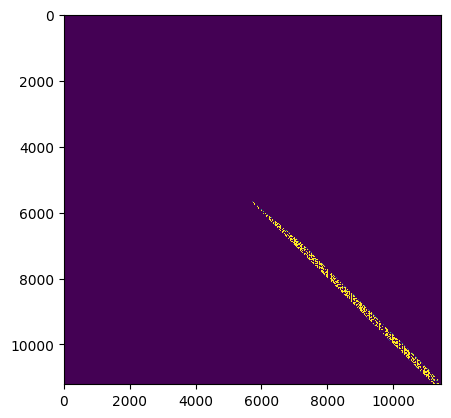

In [90]:
plt.imshow(MM, vmin= 0, vmax=1)

In [74]:
m_torch

tensor([1., 1., 1.,  ..., 1., 1., 1.], device='cuda:0')

In [68]:
torch.sum(torch.diagonal(L) == 0)

tensor(0, device='cuda:0')

In [69]:
torch.sum(torch.diagonal(U) == 0)

tensor(177, device='cuda:0')

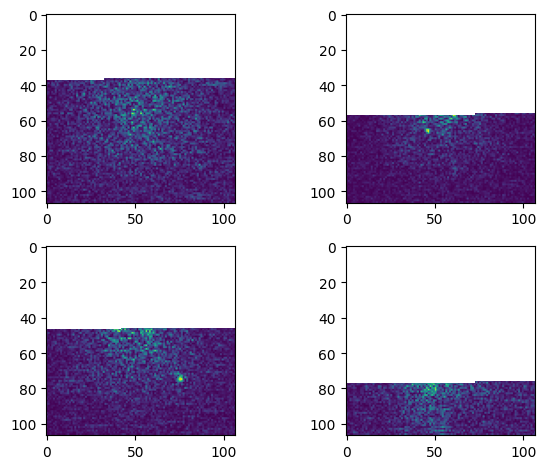

In [70]:
ax1 = plt.subplot(2, 2, 1)
ax1.imshow(torch.abs(beta_conv)[0])

ax2 = plt.subplot(2, 2, 2)
ax2.imshow(torch.abs(beta_conv[1]))

ax2 = plt.subplot(2, 2, 3)
ax2.imshow(torch.abs(beta_conv[2]))

ax2 = plt.subplot(2, 2, 4)
ax2.imshow(torch.abs(beta_conv[3]))

plt.tight_layout()

# With factors

In [12]:
# get all the data we need as pytroch tensors
X_torch = torch.from_numpy(science_data_norm).unsqueeze(1)
p_torch = torch.from_numpy(template_norm).unsqueeze(0).unsqueeze(0)
M_torch = torch.from_numpy(right_reason_mask)
eye = torch.eye(image_size**2, image_size**2) * 10000

if half_precision:
    X_torch = X_torch.float()
    p_torch = p_torch.float()
    M_torch = M_torch.float()

# send everything to the current GPU / device
X_torch = X_torch.to(rank)
p_torch = p_torch.to(rank)
M_torch = M_torch.to(rank)
eye = eye.to(rank)

# convolve the data
X_conv = F.conv2d(X_torch, p_torch, padding="same").view(X_torch.shape[0], -1)
X_conv_square = X_conv.T @ X_conv

lhs = X_conv_square + eye
LU, P_raw = torch.linalg.lu_factor(lhs)
#P, _, _ = torch.lu_unpack(LU, P_raw)

# Compute all betas in a loop over all positions
betas = []

for x, y in tqdm(positions):
    tmp_idx = x * image_size + y

    # get the current mask
    m_torch = M_torch[tmp_idx].flatten()
    Y_torch = X_torch.view(X_torch.shape[0], -1)[:, tmp_idx]
    
    # compute beta
    # compute MPX^TXPM + lambda * eye
    rhs = (X_conv * m_torch).T @ Y_torch
    
    tmp_LU = torch.diag(m_torch).double() @ LU @ torch.diag(m_torch).double() + torch.diag(torch.abs(m_torch - 1))
    beta = torch.lu_solve(rhs.view(-1,1), tmp_LU, P_raw)
    
    beta_cut = (beta.squeeze() * m_torch).cpu()

    betas.append(beta_cut.cpu())

# Convolve the results
betas_conv = torch.stack(betas).reshape(
    len(betas), 1, image_size, image_size).to(rank)

beta_conv = F.conv2d(
    betas_conv, p_torch, padding="same")

beta_conv = beta_conv.squeeze().cpu()

100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


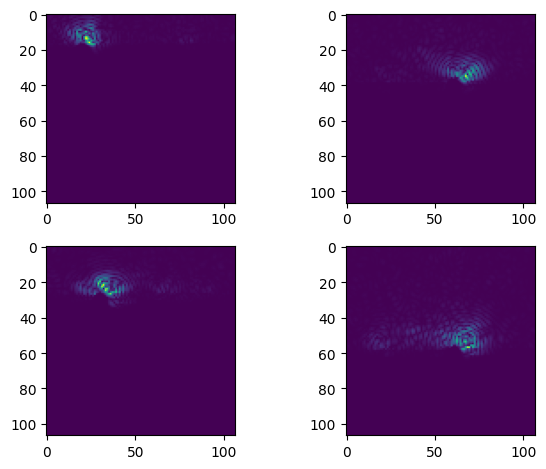

In [13]:
ax1 = plt.subplot(2, 2, 1)
ax1.imshow(torch.abs(beta_conv)[0])

ax2 = plt.subplot(2, 2, 2)
ax2.imshow(torch.abs(beta_conv[1]))

ax2 = plt.subplot(2, 2, 3)
ax2.imshow(torch.abs(beta_conv[2]))

ax2 = plt.subplot(2, 2, 4)
ax2.imshow(torch.abs(beta_conv[3]))

plt.tight_layout()

## Check the difference with pulling out the mask

In [ ]:
# get all the data we need as pytroch tensors
X_torch = torch.from_numpy(science_data_norm).unsqueeze(1)
p_torch = torch.from_numpy(template_norm).unsqueeze(0).unsqueeze(0)
M_torch = torch.from_numpy(right_reason_mask)
#eye = torch.eye(image_size**2, image_size**2) * alpha

if half_precision:
    X_torch = X_torch.float()
    p_torch = p_torch.float()
    M_torch = M_torch.float()

# send everything to the current GPU / device
X_torch = X_torch.to(rank)
p_torch = p_torch.to(rank)
M_torch = M_torch.to(rank)
#eye = eye.to(rank)

# convolve the data
X_conv = F.conv2d(X_torch, p_torch, padding="same").view(X_torch.shape[0], -1)
X_conv_square = X_conv.T @ X_conv

# Compute all betas in a loop over all positions
betas = []

for x, y in tqdm(positions):
    tmp_idx = x * image_size + y

    # get the current mask
    m_torch = M_torch[tmp_idx].flatten()
    Y_torch = X_torch.view(X_torch.shape[0], -1)[:, tmp_idx]

    # compute MPX^TXPM + lambda * eye
    eye = torch.eye(image_size**2, image_size**2, device=rank) * m_torch
    lhs = ((X_conv_square * m_torch).T * m_torch) + eye # here is the difference
    rhs = (X_conv * m_torch).T @ Y_torch

    # compute beta
    beta = torch.linalg.lstsq(lhs.cpu(), rhs.view(-1,1).cpu(), driver="gelsd")
    
    beta_cut = (beta.solution.squeeze() * m_torch.cpu()).cpu()

    betas.append(beta_cut)

# Convolve the results
betas_conv = torch.stack(betas).reshape(
    len(betas), 1, image_size, image_size).to(rank)

beta_conv = F.conv2d(
    betas_conv, p_torch, padding="same")

beta_conv = beta_conv.squeeze().cpu()

 50%|█████     | 2/4 [30:37<30:35, 917.77s/it]

In [ ]:
beta_raw = torch.stack(betas).reshape(len(betas),image_size, image_size)

In [ ]:
ax1 = plt.subplot(2, 2, 1)
ax1.imshow(torch.abs(beta_conv)[0])

ax2 = plt.subplot(2, 2, 2)
ax2.imshow(torch.abs(beta_conv[1]))

ax2 = plt.subplot(2, 2, 3)
ax2.imshow(torch.abs(beta_conv[2]))

ax2 = plt.subplot(2, 2, 4)
ax2.imshow(torch.abs(beta_conv[ 3]))

plt.tight_layout()

## Implement the math with SVD

In [84]:
half_precision = True

In [85]:
# get all the data we need as pytroch tensors
X_torch = torch.from_numpy(science_data_norm).unsqueeze(1)
p_torch = torch.from_numpy(template_norm).unsqueeze(0).unsqueeze(0)
M_torch = torch.from_numpy(right_reason_mask)

if half_precision:
    X_torch = X_torch.float()
    p_torch = p_torch.float()
    M_torch = M_torch.float()

# send everything to the current GPU / device
X_torch = X_torch.to(rank)
p_torch = p_torch.to(rank)
M_torch = M_torch.to(rank)

# convolve the data
X_conv = F.conv2d(X_torch, p_torch, padding="same").view(X_torch.shape[0], -1)

In [86]:
x, y = positions[1]
tmp_idx = x * image_size + y

In [87]:
# get the current mask
m_torch = M_torch[tmp_idx].flatten()
Y_torch = X_torch.view(X_torch.shape[0], -1)[:, tmp_idx]

In [88]:
X_conv_cut = X_conv * m_torch

In [89]:
X_conv_cut.shape

torch.Size([34666, 11449])

In [110]:
%%time
out = torch.linalg.svd(X_conv_cut, full_matrices=False, driver="gesvd")

CPU times: user 25.1 s, sys: 15.2 s, total: 40.3 s
Wall time: 40.3 s


In [111]:
U_torch = out.U
D_torch = out.S
V_torch = out.Vh.T

In [106]:
%%time
out = torch.svd_lowrank(X_conv_cut.float(),niter=1, q=5000)
U_torch = out[0]
D_torch = out[1]
V_torch = out[2]

CPU times: user 2.37 s, sys: 2.4 s, total: 4.77 s
Wall time: 4.77 s


In [112]:
%%time
betas =[]
right_side = torch.diag(D_torch) @ U_torch.T @ Y_torch
for alpha in tqdm(np.logspace(0, 6, 100)):
    eye = torch.diag(1 / (D_torch**2 + alpha*torch.ones_like(D_torch, device=rank)))
    beta = V_torch @ eye @ right_side

    beta_cut = (beta * m_torch)

    betas_conv = beta_cut.reshape(
        1, 1, image_size, image_size)

    beta_conv = F.conv2d(
        betas_conv, p_torch, padding="same")

    betas.append(beta_conv.squeeze().cpu())

100%|██████████| 100/100 [00:16<00:00,  5.92it/s]

CPU times: user 10.2 s, sys: 6.67 s, total: 16.9 s
Wall time: 16.9 s


In [113]:
from matplotlib import rcParams
import ipywidgets
from ipywidgets import interact
import IPython

In [114]:
rcParams['figure.figsize'] = (15, 6)

def generate_plots_(alpha_idx):
    
    sel_beta = betas[alpha_idx].reshape(107, 107)
    alpha = np.logspace(0, 6, 100)[alpha_idx]
    
    fig, ax = plt.subplots(1, 1)
    
    ax.imshow(torch.abs(sel_beta))
    ax.set_title("Alpha = " + str(alpha))
    
    plt.show()

# set up the interaction tools
alpha_slider = ipywidgets.SelectionSlider(
    options=np.arange(100),
    value=0,
    description='Alpha:',
    disabled=False,
    orientation='horizontal',
    readout=True,
    readout_format='d')

interact(
    generate_plots_,
    alpha_idx=alpha_slider,
);

interactive(children=(SelectionSlider(description='Alpha:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,…